In [1]:
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sns
import sklearn

import src.datasets.loading.ookla
import src.datasets.loading.statcan
import src.datasets.joins

from src.config import DATA_DIRECTORY
import time
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

In [2]:
das_info = gp.read_file(DATA_DIRECTORY / "hackathon" / "geometry.gpkg", driver="GPKG")
speed_data = pd.read_csv(DATA_DIRECTORY / "hackathon" / "speeds.csv")
speed_data.DAUID = speed_data.DAUID.astype(str)
full_data = pd.merge(das_info, speed_data)
full_data["date"] = pd.to_datetime(
    full_data["year"].astype(str)
    + "-"
    + ((full_data["quarter"] - 1) * 3 + 1).astype(str)
    + "-01"
)

In [22]:
#data procesing
selected_df = full_data[['DAUID','PCUID','PCCLASS','CENSUS_YEAR','Pop_2021','Private_Dwellings','Pop_density_square_km',
                          'Land_area_square_km','After-tax_income','Median_household_income',
                          'quarter', 'conn_type','tests','date', 'devices','avg_d_kbps','avg_u_kbps']]
#turn object type into float
columns_to_convert = ['DAUID', 'PCUID', 'PCCLASS']

for column in columns_to_convert:
    selected_df[column] = pd.to_numeric(selected_df[column], errors='coerce')
    
fixed_data = selected_df[selected_df['conn_type'] == 'fixed']
fixed_data.drop(columns=['conn_type'], inplace=True)
mobile_data = selected_df[selected_df['conn_type'] == 'mobile']
mobile_data.drop(columns=['conn_type'], inplace=True)
# fixed_data.set_index('date', inplace=True)
fixed_df = fixed_data.dropna(how='any')
#1 for rural and 0 for urban
fixed_df['area_type'] = fixed_df.apply(lambda row: 0 if row['Pop_density_square_km'] > 400 and row['Pop_2021'] >= 1000 else 1, axis=1)
fixed_df['area_type'].value_counts()
from datetime import datetime
fixed_df['year'] = fixed_df['date'].dt.year
fixed_df.drop(columns=['date'], inplace=True)



In [1]:
print(3)

3


In [29]:
from sklearn.model_selection import train_test_split
train_f, test_f = train_test_split(fixed_df, test_size=0.3, random_state=42)
train_f_y_up = train_f['avg_u_kbps']
train_f_y_down = train_f['avg_d_kbps']
train_f_x = train_f.drop(columns=['avg_d_kbps']).drop(columns=['avg_u_kbps'])
test_f_y_up = test_f['avg_u_kbps']
test_f_y_down = test_f['avg_d_kbps']
test_f_x = test_f.drop(columns=['avg_d_kbps']).drop(columns=['avg_u_kbps'])

In [30]:
# def mape_objective_function(preds, dtrain):
#     labels = dtrain.get_label()
#     grad = (preds - labels) / (0.02 + labels * np.abs(preds - labels))
#     hess = 0.01 + np.zeros(len(preds));
#     return grad, hess

# st = time.time()
# bst = xgb.XGBRegressor(colsample_bytree=0.2,
#                 gamma=0.0,
#                 learning_rate=0.05,
#                 max_depth=6,
#                 min_child_weight=1.5,
#                 n_estimators=7200,
#                 reg_alpha=0.9,
#                 reg_lambda=0.6,
#                 subsample=0.2,
#                 seed=42,
#                 obj=mape_objective_function,
#                 tree_method='gpu_hist'
#                 )

params = {
    'booster': 'gbtree',
    'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

dtrain = xgb.DMatrix(train_f_x, train_f_y_up)
num_rounds = 300
plst = list(params.items())
model = xgb.train(plst, dtrain, num_rounds)
# bst.fit(train_f_x, train_f_y_up)

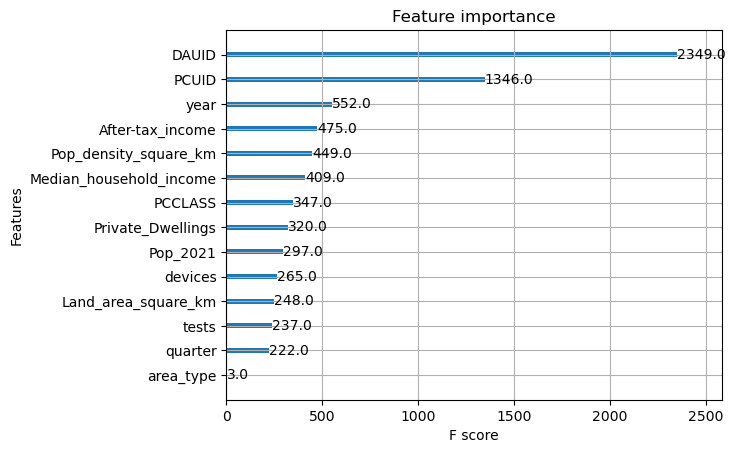

In [32]:
from xgboost import plot_importance
dtest = xgb.DMatrix(test_f_x)
ans = model.predict(dtest)

# important feature ranking
plot_importance(model)
plt.show()